## Part 1: NYC taxi data

### Basic Questions

1. What is the distribution of number of passengers per trip? (done)
2. What is the distribution of payment_type? (fares)
3. What is the distribution of fare amount? (fares)
4. What is the distribution of tip amount? (fares)
5. What is the distribution of total amount? (fares)
6. What are top 5 busiest hours of the day? (trips)
7. What are the top 10 busiest locations of the city? (trips)
8. Which trip has the highest standard deviation of travel time? (trips)
9. Which trip has most consistent fares? (fares)

### Open Questions

1. In what trips can you confidently use respective means as measures of central tendency
to estimate fare, time taken, etc.
    - Suppose it's about the fare. When we say "confidently use" we mean that knowing the mean fare should give us a resonably accurate sense of what this fare should be typically. Knowing what fare to expect helps make "right" decisions such as "ok, I'm happy to pay about 10 usd to get to Brooklyn". Or maybe "it's 10 bucks which i think is too much, i'm catching metro for 2.50". We'd use the means for the trips which cost roughly the same over the recorded 30 days, i.e. there were no clearly unusual charges ("outliers"). The reason is that outliers can strongly affect means. For example, let's say the fares for a trip recorded 10 times were about 1 dollar 9 times and then suddenly 20 dollars. The mean would be (9*1+20)/10=2.90 which is almost triple the typical ~1 dollar fare. Instead of means we'd use measures unaffected by extreme values, e.g. median which would be 1 dollar in this example - clearly, a much more accurate estimation.
2. Can we build a model to predict fare and tip amount given pick up and drop off
coordinates, time of day and week?
    - Of course. One of the simplest and yet completely usable models would be the one showing you some of measures mentioned in question 1. For example, we can put together a model that (based on the data we have) calculates median tip and mean fare for any  pair of the pickup and dropoff locations by time of day and week. Should these measures be accurate enough estimates (as discussed in question 1), we have a cheap and accurate for our purposes model on our hands. What if some pair of locations is not in the data? Then we introduce a straightforward extension: the model will now find the nearest locations for which the fare and tip amounts are avaiable, calculate the measures and produce these as the best estimates. To take this a notch higher, we can build a regression model that takes locations, time of day and week as variables.
3. If you were a taxi owner, how would you maximize your earnings in a day?
    - While there would be multiple strategies to do this, we could stick with a "greedy" approach, i.e. maximising the earnings as we go. That is, once a trip is completed all we think about is how to make the next trip most profitable and don't care about more complex strategies that may involve giving up some profits one time only to earn more another time. 
4. If you were a taxi owner, how would you minimize your work time while retaining the
average wages earned by a typical taxi in the dataset?
5. If you run a taxi company with 10 taxis, how would you maximize your earnings?

## Part 2: Open showcase
After the presentation of you results for “NYC taxi data” case, you’ll have the opportunity to present your
own work for 15 minutes.
Please illustrate with an achievement of your choice (e.g. publication, participation in the community,
portfolio, open repository, etc).

### Available Data

**Note**: many column names begin with a white space!

The **trip**-related data points are the following:

* 'medallion',
* ' hack_license',
* ' vendor_id',
* ' rate_code',
* ' store_and_fwd_flag',
* ' pickup_datetime',
* ' dropoff_datetime',
* ' passenger_count',
* ' trip_time_in_secs',
* ' trip_distance',
* ' pickup_longitude',
* ' pickup_latitude',
* ' dropoff_longitude',
* ' dropoff_latitude'

and the **fare** CSV file contains the columns as below

* 'medallion',
* ' hack_license',
* ' vendor_id',
* ' pickup_datetime',
* ' payment_type',
* ' fare_amount',
* ' surcharge',
* ' mta_tax',
* ' tip_amount',
* ' tolls_amount',
* ' total_amount'

In [1]:
import pandas as pd
import re
import seaborn as sns
import arrow
import time
from collections import Counter, defaultdict, namedtuple
import geopandas as gpd
import numpy as np
from geopy.geocoders import Nominatim

sns.set_style("whitegrid")

nom = Nominatim(user_agent='app', timeout=10)

In [4]:
class Taxi:
    
    def __init__(self, trip_file, fare_file):
        
        Location = namedtuple('Location', 'lng lat')
        
        self.EMP_STATE_BUILDING = Location(lng=-73.9856, lat=40.7484)
        
        self.extreme_trip_index = None
        self.popular_locations = None
        self.AV_TRIP_TIME = None
        self.STD_TRIP_TIME = None
        
        self.ANSWERS = defaultdict()
        
        self.FILES = {'trips': 'data/' + trip_file,
                     'fares': 'data/' + fare_file}
        self.COLS = {'latitude': [' pickup_latitude', ' dropoff_latitude'],
                     'longitude': [' pickup_longitude', ' dropoff_longitude'],
                     'useless': [' vendor_id', ' rate_code', ' store_and_fwd_flag', 
                                 ' hack_license', ' vendor_id', ' tolls_amount',
                                ' mta_tax', ' surcharge', ' tip_amount'],
                     'amount': [' fare_amount', ' tip_amount', ' total_amount']}
        
        self.distros = defaultdict(lambda: defaultdict(int))
        
    def fix_coords(self, c, lat_lng):
        
        """
        returns the original longitude or latitude rounded to 3 decimal digits if their values are not too far
        from the Empire State Building; otherwise returns None
        
        we are being very generous here weeding out only the most remote locations (0 decimal places 
        i.e. something lik 100km away) - 
        see https://en.wikipedia.org/wiki/Decimal_degrees
        """
        
        c_ = 'lng' if lat_lng == 'longitude' else 'lat' if lat_lng == 'latitude' else None
        
        if not c_:
            raise Exception(f'{self.fix_coords.__name__}: argument lat_lng is neither latitude nor longitude!')
            
        try:
            return round(float(c),3) if abs(float(c) - getattr(self.EMP_STATE_BUILDING, c_)) < 1 else None
        except:
            pass
        
    def get_and_process_data(self, show_counts=False):
        
        self.trips = pd.read_csv(self.FILES['trips'], dtype=str)
        self.trips = self.trips.drop([c for c in self.trips.columns if c in self.COLS['useless']], axis=1)
        
        self.fares = pd.read_csv(self.FILES['fares'], dtype=str)
        self.fares = self.fares.drop([c for c in self.fares.columns if c in self.COLS['useless']], axis=1)
        
        if show_counts:
            
            print(f'cabs: {self.trips["medallion"].nunique():,}')
            print(f'drivers: {self.trips[" hack_license"].nunique():,}')
            # note that the date format is 2013-04-04 18:47:45
            print(f'days: {self.trips[" pickup_datetime"].apply(lambda x: arrow.get(str(x), "YYYY-MM-DD")).nunique():,}')   
        
        for col_lst in 'longitude latitude'.split():
                  self.trips[self.COLS[col_lst]] = self.trips[self.COLS[col_lst]] \
                                                          .applymap(lambda x: self.fix_coords(c=x, lat_lng=col_lst))
        
        for s in 'pickup dropoff'.split():
                  
            avail_mask = self.trips[f' {s}_longitude'].notnull() & self.trips[f' {s}_latitude'].notnull()
            self.trips[f'{s}_loc'] = '(' + self.trips[f' {s}_longitude'].astype(str) + ', ' + self.trips[f' {s}_latitude'].astype(str) + ')'
            self.trips[f'{s}_loc'] = self.trips[f'{s}_loc'].where(avail_mask, None)
                             
        self.trips = self.trips.drop(self.COLS['latitude'] + self.COLS['longitude'], axis=1)
        
        return self
                  
    def get_passengers_per_trip(self):
        
        """
        returns a dictionary maps the number of passengeers to trip counts    
        """
                  
        # how do we define a trip in this case? "a cab with numberplate XXXX picked someone up at time TTTT" - that's a trip
        # this defines a trip in a unique way if we reasonably sssume that a specific cab can't do multiple pickupos at
        # the same time - if we do see that happening it's probably due to an error in data
                  
        TRIP_ID = ['medallion', ' pickup_datetime']
                  
        self.ANSWERS['passengers_per_trip'] = Counter(self.trips[TRIP_ID + [' passenger_count']] \
                                                              .drop_duplicates(TRIP_ID) \
                                                              .groupby(TRIP_ID) \
                                                              .sum()[' passenger_count'])
        return self
                  
    def get_busiest_hours(self, hrs=5):
                  
        """
        return the top hrs busiest hours
        """
                  
        # so what is "busiest"? let's say it's when we see the most pickups or dropoffs; we couls just stick to pickups as that
        # would reflect both the drivers and clients perspective. However, dropoffs could matter to non-taxi drivers (traffic jams)
        # hence we get the busiest hours 
        
        self.ANSWERS['busiest_hrs'] = Counter(self.trips[' pickup_datetime'].dropna().apply(lambda x: arrow.get(x).hour).tolist() + \
                                                      self.trips[' dropoff_datetime'].dropna().apply(lambda x: arrow.get(x).hour).tolist()).most_common(hrs)
        return self
                  
    def get_busiest_locations(self, n=5):
                  
        """
        return the top n busiest location
        """
                  
        # busiest locations will be those where there are most pickups and/or dropoffs 
        
        
        
        self.ANSWERS['busiest_locations'] = sorted([(k,v)for k,v in {**Counter(self.trips['pickup_loc'].dropna()), 
                                             **Counter(self.trips['dropoff_loc'].dropna())}.items()], key=lambda x: x[1], reverse=True)[:n]
        return self
                  
    def get_most_unpredictable_trip(self):
                  
        """
        return a trip with the most varying travel time
        """
        
        # this time, a trip is a tuple (pickup location, dropoff location)
        
        TRIP_ID = ['pickup_loc', 'dropoff_loc'] 
        
        self.trips[TRIP_ID + [' trip_time_in_secs']].dropna(TRIP_ID).groupby(TRIP_ID).std(ddof=0)
        

    def get_trip_stats(self, rows_at_once=50000):
        
        """
        calculates 
        
            - the number of passengers per trip
            - top 5 busiest hours of the day
            - top 10 busiest locations
            - trip with the highest std of travel time
            
        these can be used to answer questions 
        
        1. What is the distribution of number of passengers per trip? (trips)
        6. What are top 5 busiest hours of the day? (trips/fares)
        7. What are the top 10 busiest locations of the city? (trips)
        8. Which trip has the highest standard deviation of travel time? (trips)
        """
        
        # trip is defined by (medallion, pickup_datetime)
        
        useful_columns = ['medallion', ' pickup_datetime', ' passenger_count', 
                          ' pickup_longitude', ' pickup_latitude', ' dropoff_longitude', 
                          ' dropoff_latitude', ' trip_time_in_secs']
        
        travel_times_sec = list()
        
        for i, d in enumerate(pd.read_csv('data/' + self.trip_file, chunksize=rows_at_once, 
                                          usecols=useful_columns)):
            for row in d.groupby(['medallion', ' pickup_datetime']).sum().iterrows():
                self.distros['passengers'][row[0]] += row[1][' passenger_count']
                self.distros['pickup_hrs'][arrow.get(row[0][1]).hour] += 1
                
                self.distros['loc'][self._round_coords((row[1][' pickup_latitude'], row[1][' pickup_longitude']))] += 1
                self.distros['loc'][(round(row[1][' dropoff_latitude'],3), round(row[1][' dropoff_longitude'],3))] += 1
                
                travel_times_sec.append(row[1][' trip_time_in_secs'])
                
            if i and (i%10 == 0):
                print(f'done {i*rows_at_once:,} rows..')
                
        self.STD_TRIP_TIME = np.std(travel_times_sec)
        self.AV_TRIP_TIME = np.mean(travel_times_sec)
        
        self.extreme_trip_index = travel_times_sec.index(max(travel_times_sec, key=lambda x: abs(x - self.AV_TRIP_TIME)))
        
        self.popular_locations = sorted([(','.join([str(k[0]), str(k[1])]), v) 
                                   for k, v in self.distros['loc'].items()], key=lambda x: x[1], reverse=True)
        
                
        return self
    
    def get_fare_stats(self, rows_at_once=50000):
        
        """
        2. What is the distribution of payment_type? (fares)
        3. What is the distribution of fare amount? (fares)
        4. What is the distribution of tip amount? (fares)
        5. What is the distribution of total amount? (fares)
        9. Which trip has most consistent fares? (fares)
        """
        
        # we don't need all columns to answer the questions, just these:
        
        self.fares = pd.read_csv('data/' + self.fare_file, usecols=self.trip_def_cols + self.amount_cols + self.payment_type_cols)
                  
        self.fare_distros = self.fares[self.trip_def_cols + self.amount_cols] \
                                    .groupby(self.trip_def_cols) \
                                    .sum() \
                                    .reset_index(drop=True)
        
        return self
    
    def get_most_consistent_trip(self):
        
        self.trips_and_fares = pd.read_csv('data/' + self.trip_file, usecols=self.trip_def_cols + self.location_cols) \
        .join(pd.read_csv('data/' + self.fare_file, usecols=self.trip_def_cols + self.amount_cols).set_index(self.trip_def_cols),
              on = self.trip_def_cols, how='inner').drop(['medallion', ' pickup_datetime'], axis=1)
        
        self.trips_and_fares[self.location_cols] = self.trips_and_fares[self.location_cols].applymap(lambda coord: round(coord,3))
        
#         av_pick_long = self.trips_and_fares[' pickup_longitude'].astype(float).mean()
        
#         self.trips_and_fares[abs(self.trips_and_fares[' pickup_longitude'].astype(float) - av_pick_long) < 5]
        
        self.trips_and_fares['pickup_loc'] = '(' + (self.trips_and_fares[' pickup_longitude'].astype(str) + ', ' + self.trips_and_fares[' pickup_latitude'].astype(str)) + ')'
        self.trips_and_fares['dropoff_loc'] = '(' + (self.trips_and_fares[' dropoff_longitude'].astype(str) + ', ' + self.trips_and_fares[' dropoff_latitude'].astype(str)) + ')'
       
        self.trips_and_fares = self.trips_and_fares.drop(self.location_cols, axis=1)
        
        # we only consider trips made 5 times or more
        c_ = self.trips_and_fares[['pickup_loc', 'dropoff_loc', ' fare_amount']].groupby(['pickup_loc', 'dropoff_loc']).count()
        c_.columns = ['n']
        c_ = c_[c_['n'] >= 5]
        print(c_.head())
        
        self.fare_stds = self.trips_and_fares.join(c_, on=['pickup_loc', 'dropoff_loc'], how='inner').groupby(['pickup_loc', 'dropoff_loc']).std(ddof=0)
        
#         self.fare_stds = self.fare_stds[self.fare_stds[' total_amount'].astype(float) > 0]
        
        return self
        
        
        

In [5]:
if __name__ == '__main__':
    
    t0 = time.time()
    tx = Taxi(trip_file='trip_data_4.csv', fare_file='trip_fare_4.csv') \
                        .get_and_process_data() \
                            .get_busiest_hours() \
                            .get_busiest_locations() \
                            .get_passengers_per_trip()
    t1 = time.time()
    m, s = divmod(t1-t0, 60)
    print(f'elapsed time: {m:.0f} m {s:.0f} s')

elapsed time: 96 m 17 s


In [6]:
tx.trips.head()

,medallion,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_loc,dropoff_loc
0,91F6EB84975BBC867E32CB113C7C2CD5,2013-04-04 18:47:45,2013-04-04 19:00:25,1,759,2.50,"(-73.958, 40.765)","(-73.976, 40.786)"
1,EC34CD1B3797DFAFF3FE099BA87B6656,2013-04-05 07:08:34,2013-04-05 07:17:34,1,540,1.60,None,None
2,C1B9DA774DC2BBC6DE27CE994E7F44A0,2013-04-04 17:59:50,2013-04-04 18:21:48,1,1318,3.60,"(-73.983, 40.755)","(-74.009, 40.715)"
3,9BA84250355AB3FC031C9252D395BF8A,2013-04-04 18:12:01,2013-04-04 18:25:24,1,799,1.90,"(-73.978, 40.763)","(-73.956, 40.777)"
4,205A696DF62AD03C88DA8C5EC5248639,2013-04-04 20:12:57,2013-04-04 20:29:55,1,1017,3.60,"(-74.006, 40.745)","(-73.962, 40.761)"


In [7]:
tx.ANSWERS

defaultdict(None,
            {'busiest_hrs': [(19, 1924302),
              (20, 1842826),
              (18, 1828164),
              (21, 1769905),
              (22, 1712745)],
             'busiest_locations': [('(-73.991, 40.75)', 60535),
              ('(-73.995, 40.75)', 45893),
              ('(-73.992, 40.749)', 45078),
              ('(-73.991, 40.751)', 44271),
              ('(-73.871, 40.774)', 28043)],
             'passengers_per_trip': Counter({'1': 10706344,
                      '2': 1985636,
                      '3': 609816,
                      '4': 298124,
                      '5': 890070,
                      '6': 609282,
                      '0': 229,
                      '8': 1,
                      '9': 1})})

In [8]:
tx.trips.head()

,medallion,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_loc,dropoff_loc
0,91F6EB84975BBC867E32CB113C7C2CD5,2013-04-04 18:47:45,2013-04-04 19:00:25,1,759,2.50,"(-73.958, 40.765)","(-73.976, 40.786)"
1,EC34CD1B3797DFAFF3FE099BA87B6656,2013-04-05 07:08:34,2013-04-05 07:17:34,1,540,1.60,None,None
2,C1B9DA774DC2BBC6DE27CE994E7F44A0,2013-04-04 17:59:50,2013-04-04 18:21:48,1,1318,3.60,"(-73.983, 40.755)","(-74.009, 40.715)"
3,9BA84250355AB3FC031C9252D395BF8A,2013-04-04 18:12:01,2013-04-04 18:25:24,1,799,1.90,"(-73.978, 40.763)","(-73.956, 40.777)"
4,205A696DF62AD03C88DA8C5EC5248639,2013-04-04 20:12:57,2013-04-04 20:29:55,1,1017,3.60,"(-74.006, 40.745)","(-73.962, 40.761)"


In [3]:
TRIP_ID = ['pickup_loc', 'dropoff_loc'] 
        
d1 = tx.trips[TRIP_ID + [' trip_time_in_secs']].dropna(subset=TRIP_ID + [' trip_time_in_secs']).groupby(TRIP_ID).count()
d1 = d1[d1[' trip_time_in_secs'].astype(int) > 6].rename(columns={' trip_time_in_secs': 'total_trips'})
d1['total_trips'] = d1['total_trips'].astype(float)
d2 = tx.trips[TRIP_ID + [' trip_time_in_secs']].join(d1, how='inner', on=TRIP_ID)

NameError: name 'tx' is not defined

In [51]:
d3 = d2.groupby(TRIP_ID).std()
# [' trip_time_in_secs'].idxmax()

In [49]:
d1.head()

,,total_trips
pickup_loc,dropoff_loc,
"(-73.203, 41.229)","(-73.203, 41.229)",11
"(-73.42, 40.863)","(-73.42, 40.863)",9
"(-73.521, 40.711)","(-73.521, 40.711)",55
"(-73.532, 40.779)","(-73.532, 40.779)",7
"(-73.659, 40.751)","(-73.659, 40.751)",24


In [53]:
d2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5845607 entries, 3 to 15012385
Data columns (total 4 columns):
pickup_loc            object
dropoff_loc           object
 trip_time_in_secs    object
total_trips           int64
dtypes: int64(1), object(3)
memory usage: 223.0+ MB


In [52]:
d3.head()

,,total_trips
pickup_loc,dropoff_loc,
"(-73.203, 41.229)","(-73.203, 41.229)",0.0
"(-73.42, 40.863)","(-73.42, 40.863)",0.0
"(-73.521, 40.711)","(-73.521, 40.711)",0.0
"(-73.532, 40.779)","(-73.532, 40.779)",0.0
"(-73.659, 40.751)","(-73.659, 40.751)",0.0


In [31]:
tx.trips[TRIP_ID + [' trip_time_in_secs']].dropna(subset=TRIP_ID + [' trip_time_in_secs']).groupby(TRIP_ID).count().reset_index()

,pickup_loc,dropoff_loc,trip_time_in_secs
0,"(-73.0, 40.781)","(-73.938, 40.856)",1
1,"(-73.002, 40.571)","(-73.002, 40.571)",1
2,"(-73.021, 40.822)","(-73.021, 40.822)",1
3,"(-73.041, 40.564)","(-73.981, 40.787)",1
4,"(-73.05, 40.771)","(-74.0, 40.731)",1
5,"(-73.075, 40.875)","(-73.079, 40.868)",1
6,"(-73.076, 40.845)","(-73.082, 40.866)",1
7,"(-73.085, 40.15)","(-73.086, 40.155)",1
8,"(-73.087, 40.157)","(-73.09, 40.161)",1
9,"(-73.09, 40.128)","(-73.089, 40.141)",1


In [25]:
d1.head()

,,total_trips
pickup_loc,dropoff_loc,
"(-73.171, 40.815)","(-73.171, 40.815)",5
"(-73.203, 41.229)","(-73.203, 41.229)",11
"(-73.42, 40.863)","(-73.42, 40.863)",9
"(-73.422, 40.784)","(-73.422, 40.784)",4
"(-73.425, 40.763)","(-73.425, 40.763)",3


In [20]:
d1.head()

,,total_trips
pickup_loc,dropoff_loc,
"(-73.171, 40.815)","(-73.171, 40.815)",5
"(-73.203, 41.229)","(-73.203, 41.229)",11
"(-73.42, 40.863)","(-73.42, 40.863)",9
"(-73.422, 40.784)","(-73.422, 40.784)",4
"(-73.425, 40.763)","(-73.425, 40.763)",3


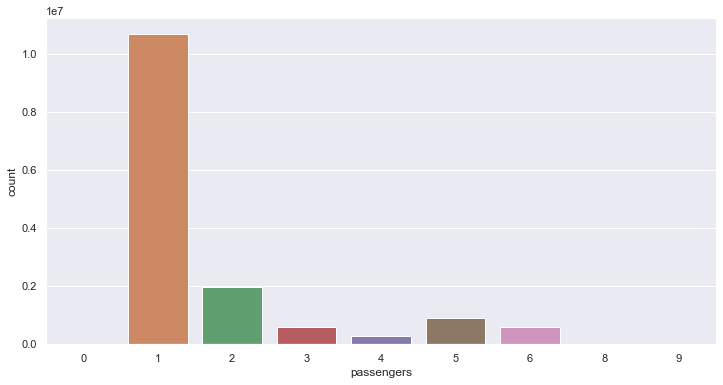

In [83]:
sns.set(rc={'figure.figsize':(12,6)})

sns.barplot(data=pd.DataFrame.from_dict(tx.ANSWERS['passengers_per_trip'], orient='index').reset_index().rename(columns={'index':'passengers', 0: 'count'}), x='passengers', y='count')

,0,1
0,19,1924302
1,20,1842826
2,18,1828164
3,21,1769905
4,22,1712745


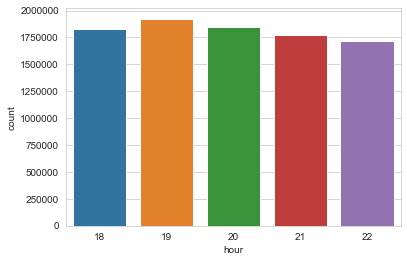

In [12]:
sns.barplot(data=pd.DataFrame.from_records(tx.ANSWERS['busiest_hrs']) \
            .rename(columns={0: 'hour', 1: 'count'}), x='hour', y='count')

In [9]:
df = gpd.read_file(gpd.datasets.get_path('nybb'))

In [10]:
df.head()

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,(POLYGON ((970217.0223999023 145643.3322143555...
1,4,Queens,896344.047763,3.045213e+09,(POLYGON ((1029606.076599121 156073.8142089844...
2,3,Brooklyn,741080.523166,1.937479e+09,(POLYGON ((1021176.479003906 151374.7969970703...
3,1,Manhattan,359299.096471,6.364715e+08,(POLYGON ((981219.0557861328 188655.3157958984...
4,2,Bronx,464392.991824,1.186925e+09,(POLYGON ((1012821.805786133 229228.2645874023...


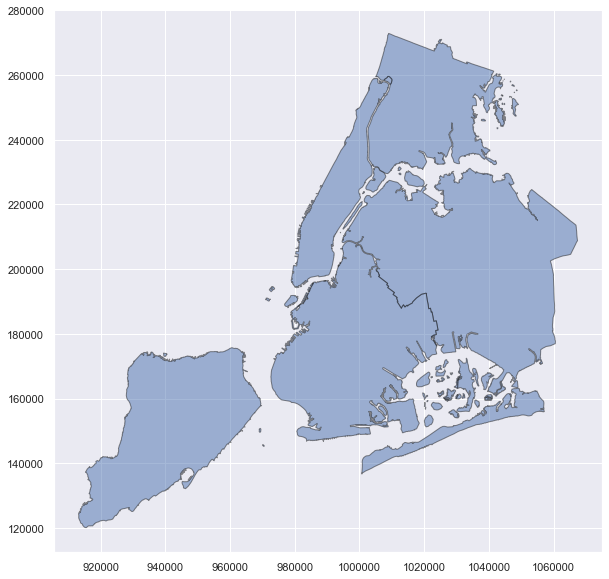

In [11]:
ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

In [5]:
Location = namedtuple('Location', 'lng lat')

In [6]:
ESB = Location(lng=-73.9856, lat=40.7484)

In [11]:
getattr(ESB, 'lng')

-73.9856